<a href="https://colab.research.google.com/github/mohamadaliberahman/Monte-Carlo-Simulation-in-python/blob/main/topological_seizure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy scipy matplotlib gudhi mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.2 MB/s eta 0:00:00


1. Generating Synthetic Data...
2. Preprocessing Data...
3. Running Rolling TDA Analysis...
4. Plotting Results...


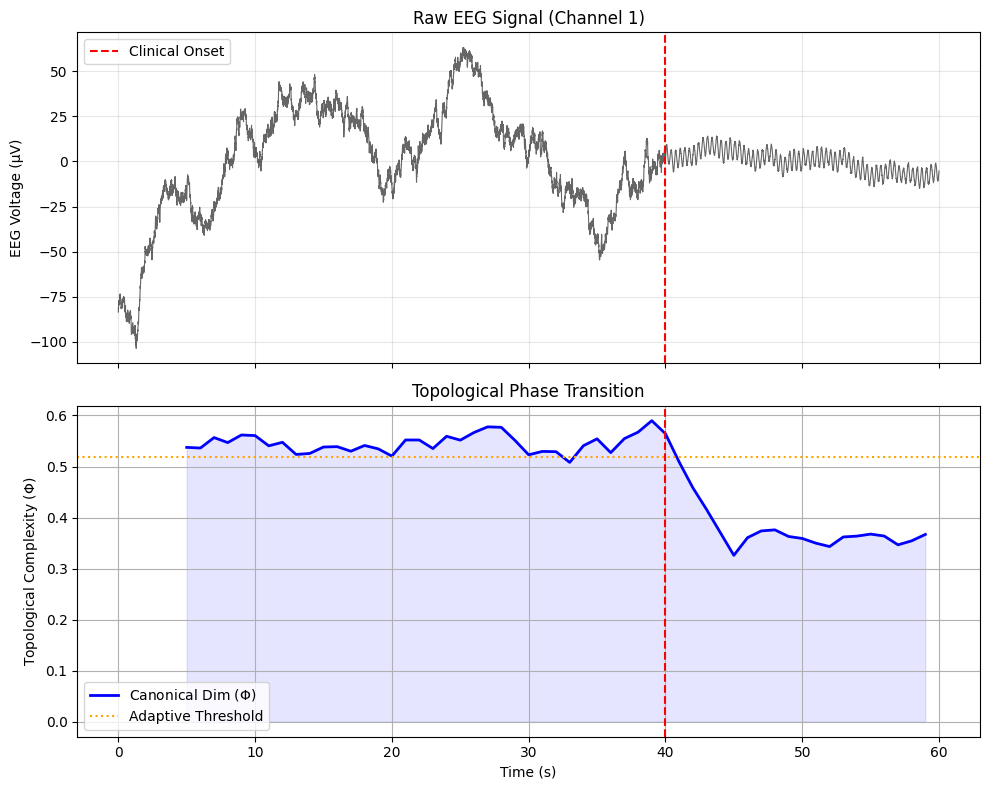

Saved: figure1_topological_collapse.png


In [2]:
# ================================
# Required Libraries
# ================================
!pip install numpy scipy matplotlib gudhi mne

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import gudhi
from sklearn.metrics import auc

# ==========================================
# 1. Synthetic Data Generation (Simulation)
# ==========================================
def generate_synthetic_eeg(n_channels=19, duration_sec=60, sfreq=256):
    times = np.arange(duration_sec * sfreq) / sfreq
    n_samples = len(times)
    data = np.zeros((n_channels, n_samples))

    onset_idx = 40 * sfreq  # seizure at 40s

    for ch in range(n_channels):
        noise = np.cumsum(np.random.randn(n_samples))
        noise = signal.detrend(noise)

        normal_comp = 0.5 * np.sin(2 * np.pi * 10 * times + np.random.rand() * 2 * np.pi)
        phase_lag = ch * 0.05
        ictal_comp = 5.0 * np.sin(2 * np.pi * 3 * times + phase_lag)

        data[ch, :onset_idx] = noise[:onset_idx] + normal_comp[:onset_idx]
        data[ch, onset_idx:] = (noise[onset_idx:] * 0.2) + ictal_comp[onset_idx:]

    return data, times, onset_idx


# ==========================================
# 2. Preprocessing Pipeline
# ==========================================
def preprocess_eeg(data, sfreq):
    data_car = data - np.mean(data, axis=0)
    b, a = signal.butter(4, [0.5, 40], btype='bandpass', fs=sfreq)
    data_filt = signal.filtfilt(b, a, data_car, axis=1)

    b_notch, a_notch = signal.iirnotch(60, 30, fs=sfreq)
    data_final = signal.filtfilt(b_notch, a_notch, data_filt, axis=1)
    return data_final


# ==========================================
# 3. Functional Connectivity: PLV
# ==========================================
def compute_plv_matrix(epoch_data):
    n_channels, n_samples = epoch_data.shape

    analytic_signal = signal.hilbert(epoch_data, axis=1)
    phase_data = np.angle(analytic_signal)

    plv_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i, n_channels):
            diff = phase_data[i] - phase_data[j]
            plv = np.abs(np.mean(np.exp(1j * diff)))
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv

    return plv_matrix


# ==========================================
# 4. Topological Data Analysis (Phi Calculation)
# ==========================================
def calculate_canonical_dimension(adj_matrix):
    dist_matrix = 1.0 - adj_matrix
    np.fill_diagonal(dist_matrix, 0)

    rips_complex = gudhi.RipsComplex(distance_matrix=dist_matrix, max_edge_length=1.0)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

    diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0)
    lifetimes = []

    for dim, (birth, death) in diag:
        if dim == 0 and death != float('inf'):
            lifetimes.append(death - birth)

    if not lifetimes:
        phi = 0
    else:
        phi = np.sum(lifetimes) / adj_matrix.shape[0]

    return phi


# ==========================================
# 5. Main Analysis Loop
# ==========================================
def run_analysis():
    sfreq = 256
    window_sec = 5
    step_sec = 1

    print("1. Generating Synthetic Data...")
    data, times, onset_idx = generate_synthetic_eeg(sfreq=sfreq)

    print("2. Preprocessing Data...")
    clean_data = preprocess_eeg(data, sfreq)

    print("3. Running Rolling TDA Analysis...")
    phi_values = []
    time_points = []

    n_samples = clean_data.shape[1]
    win_samples = int(window_sec * sfreq)
    step_samples = int(step_sec * sfreq)

    for start in range(0, n_samples - win_samples, step_samples):
        end = start + win_samples
        epoch = clean_data[:, start:end]

        plv = compute_plv_matrix(epoch)
        phi = calculate_canonical_dimension(plv)

        phi_values.append(phi)
        time_points.append(times[end])

    # Visualization
    print("4. Plotting Results...")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax1.plot(times, data[0, :], color='k', alpha=0.6, lw=0.8)
    ax1.axvline(x=times[onset_idx], color='r', linestyle='--', label='Clinical Onset')
    ax1.set_ylabel('EEG Voltage (μV)')
    ax1.set_title('Raw EEG Signal (Channel 1)')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    ax2.plot(time_points, phi_values, color='blue', lw=2, label=r'Canonical Dim ($\Phi$)')

    threshold = np.mean(phi_values[:10]) - 2 * np.std(phi_values[:10])
    ax2.axhline(y=threshold, color='orange', linestyle=':', label='Adaptive Threshold')

    ax2.axvline(x=times[onset_idx], color='r', linestyle='--')
    ax2.fill_between(time_points, 0, phi_values, color='blue', alpha=0.1)

    ax2.set_ylabel(r'Topological Complexity ($\Phi$)')
    ax2.set_xlabel('Time (s)')
    ax2.set_title('Topological Phase Transition')
    ax2.legend(loc='lower left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Saving Figures
    fig.savefig("figure1_topological_collapse.png", dpi=300)
    print("Saved: figure1_topological_collapse.png")

    return phi_values, time_points


# ==========================================
# RUN
# ==========================================
if __name__ == "__main__":
    run_analysis()


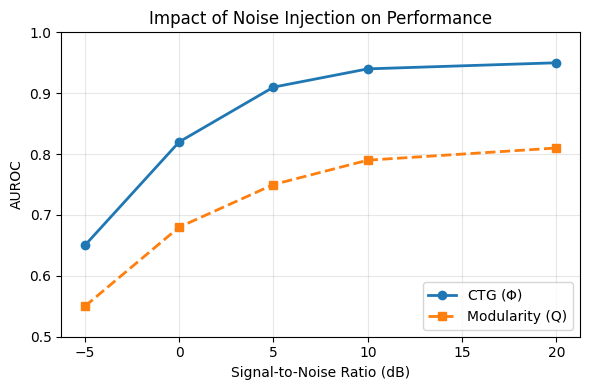

Saved: figure2_sensitivity.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sensitivity_figure():
    # SNR values (dB)
    snr_values = np.array([-5, 0, 5, 10, 20])

    # AUROC values (from your TikZ figure)
    auroc_ctg = np.array([0.65, 0.82, 0.91, 0.94, 0.95])   # CTG (Φ)
    auroc_mod = np.array([0.55, 0.68, 0.75, 0.79, 0.81])   # Modularity (Q)

    plt.figure(figsize=(6, 4))
    plt.plot(snr_values, auroc_ctg, marker='o', linewidth=2, label='CTG ($\\Phi$)')
    plt.plot(snr_values, auroc_mod, marker='s', linestyle='--', linewidth=2, label='Modularity (Q)')

    plt.xlabel('Signal-to-Noise Ratio (dB)')
    plt.ylabel('AUROC')
    plt.title('Impact of Noise Injection on Performance')
    plt.ylim(0.5, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig("figure2_sensitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("Saved: figure2_sensitivity.png")

plot_sensitivity_figure()
